In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh
import random

<p style='font-size:18px'><b> Level 2 Model EDA </b></p>
<p>

- After applying the Level 1 model, we filtered some points to be 'not-fraud' & the rest of the points will be used as train data for level 2 model.
- We will now apply similar EDA steps on this train data as we did for the original dataset.
    
</p>


In [2]:
# Load the dataset for level 2
raw_data = pd.read_csv('dataset/creditcard_train_l2.csv')

In [3]:
print("1. Number of rows (datapoints): ", raw_data.shape[0])
print("2. Number of cols (features+label): ", raw_data.shape[1])
print("\n3. Column names: ", raw_data.columns)
labels, counts = np.unique(raw_data.Class, return_counts = True)
print("\n4. Unique label values: ", labels)
print("5. Label counts: ", counts)
print("6. % of fraud transactions: {}%".format(round(100*counts[1]/(counts[0]+counts[1]),3)))
total_amount = np.sum(raw_data.Amount)
fraud_amount = np.sum(raw_data.Amount.loc[(raw_data.Class == 1)])
print("7. % of fraud transaction amount: {}%".format(round(100*fraud_amount/total_amount,3)))
print("\n8a. Total transaction amount: {}lacs".format(round(total_amount/100000, 1)))
print("8b. Fraud transactions amount: {}lacs".format(round(fraud_amount/100000, 1)))
print("\n9a. Average value of non-fraud transaction: ", round((total_amount-fraud_amount)/(raw_data.shape[0] - counts[1])))
print("9b. Average value of fraud transaction: ", round((fraud_amount)/(counts[1])))
print("\n8. Sample datapoints: ")

raw_data.iloc[np.random.randint(0,raw_data.shape[0],5)]

1. Number of rows (datapoints):  30669
2. Number of cols (features+label):  32

3. Column names:  Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Hour_num'],
      dtype='object')

4. Unique label values:  [0 1]
5. Label counts:  [30296   373]
6. % of fraud transactions: 1.216%
7. % of fraud transaction amount: 1.121%

8a. Total transaction amount: 35.5lacs
8b. Fraud transactions amount: 0.4lacs

9a. Average value of non-fraud transaction:  116
9b. Average value of fraud transaction:  107

8. Sample datapoints: 


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour_num
26687,15237.0,-1.730577,-1.17183,1.944349,2.340095,-2.450569,1.831426,2.690772,-0.168146,1.659915,...,-0.566333,1.659504,0.465175,0.135857,-0.493839,0.005001,0.013779,735.09,0,4
9756,30073.0,-6.037393,5.36532,-9.780794,4.193648,-5.104391,-3.156852,-6.472880,4.320926,-2.537853,...,-0.586822,-0.102259,-0.047552,0.183755,-0.282898,1.231827,0.284507,89.99,0,8
23874,157986.0,0.147052,1.08304,-0.402870,-0.553269,0.972539,-0.803216,1.031770,-0.149295,-0.150102,...,-0.783633,0.089315,0.577336,-0.393884,0.111354,0.226050,0.085689,5.55,0,43
17992,60369.0,-2.207967,-0.24085,-1.772559,2.301079,-2.742125,0.046835,2.730258,0.229033,-0.685382,...,0.252100,1.075805,0.602553,-0.104766,-0.255457,0.470358,-0.558678,649.54,0,16
29307,149097.0,2.052436,0.08979,-1.809133,0.233581,0.605778,-0.389994,0.067764,-0.063191,0.274229,...,-0.897438,0.292148,0.182237,-0.253198,0.172957,-0.067793,-0.043872,1.98,0,41


1. Feature # randomly selected:  [ 1 18 19 27]
2. Legend: 
Fraud datapoints - Red
Not fraud datapoints - Blue 


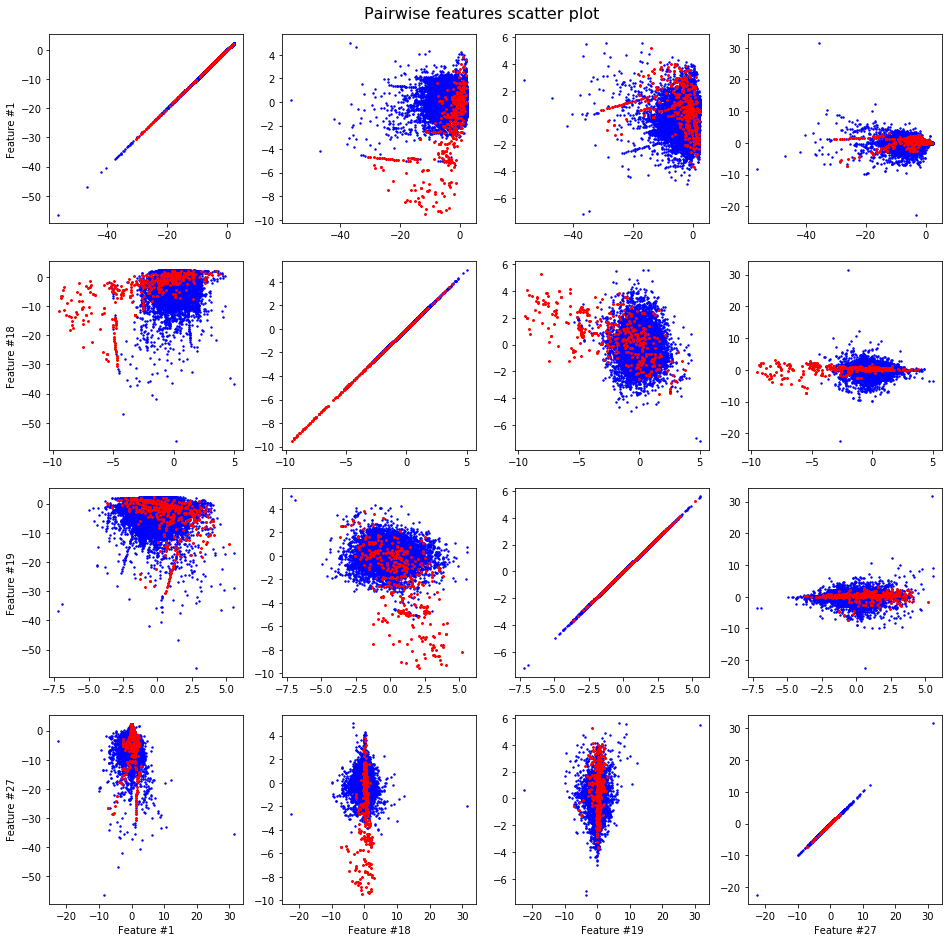

In [6]:
# Select 10 features at random and plot pair-wise scatter plot

def pairwise_plot(row, col, axs):
    
    global feature_data, feature_ind, num_features
    
    f1 = feature_ind[row]
    f2 = feature_ind[col]
    
    x = feature_data.iloc[:, f1].to_numpy()
    y = feature_data.iloc[:, f2].to_numpy()
    
    x_pos = x[(feature_data.Class == 1)]
    y_pos = y[(feature_data.Class == 1)]
    x_neg = x[(feature_data.Class == 0)]
    y_neg = y[(feature_data.Class == 0)]
    
    axs.scatter(x_neg, y_neg, label = 'Not Fraud', s = 2, c = 'b')
    axs.scatter(x_pos, y_pos, label = 'Fraud', s = 4, c = 'r', marker = 'x')

    if row == num_features-1:
        x_lab = 'Feature #' + str(f2+1)
        axs.set(xlabel = x_lab)
    if col == 0:
        y_lab = 'Feature #' + str(f1+1)
        axs.set(ylabel = y_lab)
        

# Select features at random (num_features = 4) to visualise pairwise-plots
num_features = 4
# feature_ind = np.sort(np.array(random.sample(range(28), num_features)))

# Select features in particular (num_features = 4) to visualise pairwise-plots
feature_ind = np.array([0, 17, 18, 26])

fig_size = min(16, 4*num_features)

# Setting up the pairwise plot
fig = plt.figure(figsize = (fig_size,fig_size))
fig.subplots_adjust(wspace = 0.2)
fig.suptitle('Pairwise features scatter plot', fontsize = 16, y = 0.9 + 0.001*num_features)
axs = fig.subplots(num_features,num_features)

for i in range(num_features**2):
    row = i//num_features
    col = i%num_features
    pairwise_plot(row, col, axs[row, col])

print("1. Feature # randomly selected: ", feature_ind+1)
print("2. Legend: \nFraud datapoints - Red\nNot fraud datapoints - Blue ")

<p style='font-size:16px'><b> Inferences </b></p>
<p>

- As compared to the plots in L1a_EDA, we have removed a significant number of blue points (not-fraud) from the dataset.
- E.g compare the plot betweeen feature # 18 vs feature # 19 before & after L1 filtering by referring to the plots in L1a_EDA.
    
</p>



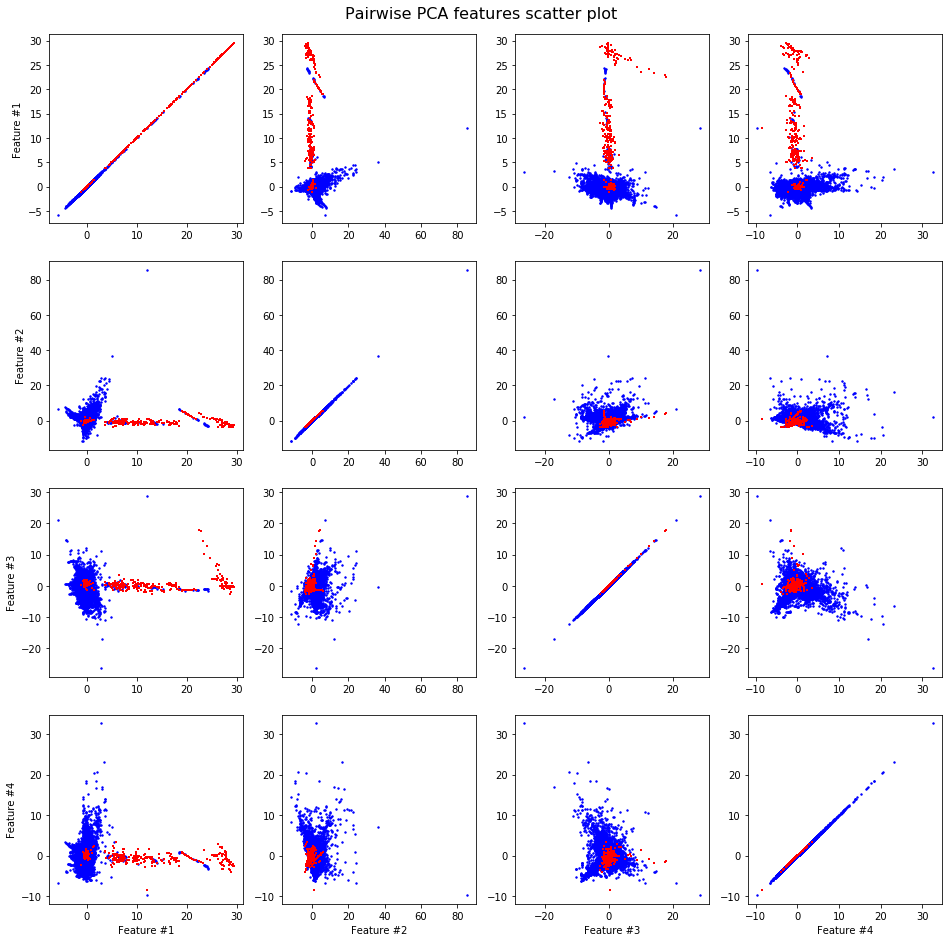

In [7]:
# Apply PCA to get top features & visualize using pair-wise plots

def pairwise_pca_plot(row, col, axs):

    global x_pca_dim, num_components, y_label
    
    x = x_pca_dim[:, col]
    y = x_pca_dim[:, row]
    
    x_pos = x[(y_label == 1)]
    y_pos = y[(y_label == 1)]
    x_neg = x[(y_label == 0)]
    y_neg = y[(y_label == 0)]

    axs.scatter(x_neg, y_neg, label = 'Not Fraud', s = 2, c = 'b')
    axs.scatter(x_pos, y_pos, label = 'Fraud', s = 4, c = 'r', marker = '+')

    if row == num_components-1:
        x_lab = 'Feature #' + str(col+1)
        axs.set(xlabel = x_lab)
    if col == 0:
        y_lab = 'Feature #' + str(row+1)
        axs.set(ylabel = y_lab)

    
# Standardizing the data - necessary for PCA
x = feature_data.iloc[:,:-1].to_numpy()
y_label = feature_data.iloc[:,-1].to_numpy()

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Apply PCA - select the number of components
num_components = 4    #Imp: Don't increase this value beyond 5
pca = decomposition.PCA(n_components=num_components)
x_pca_dim = pca.fit_transform(x_scaled)

# Setting up the pairwise plot
fig_size = min(num_components*4, 16)
fig = plt.figure(figsize = (fig_size,fig_size))
fig.subplots_adjust(wspace = 0.2)
fig.suptitle('Pairwise PCA features scatter plot', fontsize = 16, y = 0.9 + 0.001*num_features)
axs = fig.subplots(num_components,num_components)

for i in range(num_components**2):
    row = i//num_components
    col = i%num_components
    pairwise_pca_plot(row, col, axs[row, col])


<p style='font-size:16px'><b> Inferences </b></p>
<p>

This is where we see the most significant differences, for e.g the separate clusters as visible in PCA feature #1 vs PCA feature #2 were not as apparent previously before L1a_EDA filter.
    
</p>

